In [15]:
IMAGE_SIZE = 64
IMAGES_PER_CLASS = 2000
CLASSES = ['11212', '2456', '2780', '3001', '3002', '3003', '3004', '3005', '3006', '3007', '3008', '3009', '3010', '3020', '3021', '3022', '3023', '3024']

In [16]:
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
try:
    API_KEY = os.environ["REBRICKABLE_API_KEY"]
except:
    print('Please add your Rebrickable API Key to the project as instructed in the README.')

In [17]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import tqdm
import requests as r

class LegoDataset(Dataset):
    def __init__(self, dataset_path):

        # Init output data
        x_data = []
        y_data = []
        labels = []

        encoding = { 'woohoo!': -1 }
        
        # For each class folder
        for label in os.listdir(dataset_path):

            # Only account for certain classes, ignore others
            if label in CLASSES:

                # Initialize variables to retrieve and store images
                curr_path = dataset_path + "/" + label

                # For each image
                for filename in tqdm.tqdm(os.listdir(curr_path)[:IMAGES_PER_CLASS]):

                    # Store image in tensor representation
                    image_path = curr_path + "/" + filename
                    image_tensor = read_image(image_path)

                    # Add tensor to data dictionary
                    x_data.append(image_tensor / 255.0)
                    if label not in encoding:
                        encoding[label] = max(list(encoding.values())) + 1
                    y_data.append(encoding[label])
                    labels.append(label)

        self.x_data = x_data
        self.y_data = y_data
        self.labels = set(labels)

        rebrickable_query = 'https://rebrickable.com/api/v3/lego/parts/?key=' + API_KEY + '&part_nums='
        for label in self.labels:
            rebrickable_query += label + ','

        self.brick_info = {}
        response = r.get(rebrickable_query).json()
        for entry in response['results']:
            self.brick_info[entry['part_num']] = entry

        self.brick_info = pd.DataFrame(self.brick_info).T

    def __len__(self):
        assert len(self.x_data) == len(self.y_data)
        return len(self.x_data)

    def __getitem__(self, idx):
        return (self.x_data[idx], self.y_data[idx])

In [18]:
dataset = LegoDataset('dataset')

100%|██████████| 2000/2000 [00:01<00:00, 1616.39it/s]


In [19]:
dataset.brick_info

,part_num,name,part_cat_id,part_url,part_img_url,external_ids,print_of
11212,11212,Plate 3 x 3,14,https://rebrickable.com/parts/11212/plate-3-x-3/,https://cdn.rebrickable.com/media/parts/elemen...,"{'BrickLink': ['11212'], 'BrickOwl': ['855115'...",None
2456,2456,Brick 2 x 6,11,https://rebrickable.com/parts/2456/brick-2-x-6/,https://cdn.rebrickable.com/media/parts/elemen...,"{'BrickLink': ['2456'], 'BrickOwl': ['448968']...",None
2780,2780,Technic Pin with Friction Ridges Lengthwise an...,53,https://rebrickable.com/parts/2780/technic-pin...,https://cdn.rebrickable.com/media/parts/elemen...,"{'BrickLink': ['2780'], 'BrickOwl': ['33899'],...",None
3001,3001,Brick 2 x 4,11,https://rebrickable.com/parts/3001/brick-2-x-4/,https://cdn.rebrickable.com/media/parts/elemen...,"{'BrickLink': ['3001'], 'BrickOwl': ['771344']...",None
3002,3002,Brick 2 x 3,11,https://rebrickable.com/parts/3002/brick-2-x-3/,https://cdn.rebrickable.com/media/parts/elemen...,"{'BrickLink': ['3002'], 'BrickOwl': ['462227']...",None
3003,3003,Brick 2 x 2,11,https://rebrickable.com/parts/3003/brick-2-x-2/,https://cdn.rebrickable.com/media/parts/elemen...,"{'BrickLink': ['3003'], 'BrickOwl': ['3003', '...",None
3004,3004,Brick 1 x 2,11,https://rebrickable.com/parts/3004/brick-1-x-2/,https://cdn.rebrickable.com/media/parts/elemen...,"{'BrickLink': ['3004'], 'BrickOwl': ['442413']...",None
3005,3005,Brick 1 x 1,11,https://rebrickable.com/parts/3005/brick-1-x-1/,https://cdn.rebrickable.com/media/parts/elemen...,"{'BrickLink': ['3005'], 'BrickOwl': ['656416']...",None
3008,3008,Brick 1 x 8,11,https://rebrickable.com/parts/3008/brick-1-x-8/,https://cdn.rebrickable.com/media/parts/elemen...,"{'BrickLink': ['3008'], 'BrickOwl': ['273019']...",None
3009,3009,Brick 1 x 6,11,https://rebrickable.com/parts/3009/brick-1-x-6/,https://cdn.rebrickable.com/media/parts/elemen...,"{'BrickLink': ['3009'], 'BrickOwl': ['340943']...",None


In [42]:
import torch.utils.data
from torch.utils.data import DataLoader

train_data, test_data = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.8), int(len(dataset) * 0.2)])
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

Feature batch shape: torch.Size([32, 3, 64, 64])
Labels batch shape: torch.Size([32])


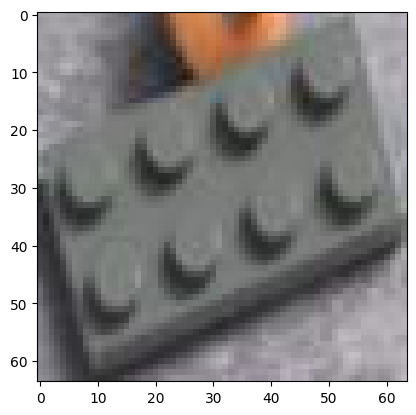

Label: 11


In [43]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.shape}")
print(f"Labels batch shape: {train_labels.shape}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.T, cmap="gray")
plt.show()
print(f"Label: {label}")

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.conv2 = nn.Conv2d(10, 32, 8)
        self.conv3 = nn.Conv2d(32, 64, 4)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(64, 512)  # 5*5 from image dimension
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 2048)
        self.fc4 = nn.Linear(2048, 200)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 3)
        x = F.max_pool2d(F.relu(self.conv2(x)), 3)
        x = F.max_pool2d(F.relu(self.conv3(x)), 1)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


net = Net().cpu()
print(net.to(torch.device('cpu')))

Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 32, kernel_size=(8, 8), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=64, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=2048, bias=True)
  (fc4): Linear(in_features=2048, out_features=200, bias=True)
)


In [49]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [47]:
loss_over_time = []

for epoch in range(25):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
            loss_over_time.append(running_loss)
            running_loss = 0.0

    size = len(test_dataloader.dataset)
    num_batches = len(test_dataloader)
    net.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred = net(X)
            test_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

[1,   100] loss: 28.035
[1,   200] loss: 28.005
[1,   300] loss: 27.829
[1,   400] loss: 27.008
[1,   500] loss: 26.516
[1,   600] loss: 25.963
[1,   700] loss: 26.098
[1,   800] loss: 25.127
Test Error: 
 Accuracy: 13.2%, Avg loss: 2.448427 

[2,   100] loss: 24.350
[2,   200] loss: 23.794
[2,   300] loss: 21.997
[2,   400] loss: 21.054
[2,   500] loss: 19.423
[2,   600] loss: 18.230
[2,   700] loss: 17.586
[2,   800] loss: 16.918
Test Error: 
 Accuracy: 38.6%, Avg loss: 1.716557 

[3,   100] loss: 16.337
[3,   200] loss: 15.067
[3,   300] loss: 15.178
[3,   400] loss: 14.678
[3,   500] loss: 14.228
[3,   600] loss: 13.690
[3,   700] loss: 13.691
[3,   800] loss: 13.028
Test Error: 
 Accuracy: 55.7%, Avg loss: 1.282539 

[4,   100] loss: 12.114
[4,   200] loss: 12.933
[4,   300] loss: 12.190
[4,   400] loss: 11.766
[4,   500] loss: 12.088
[4,   600] loss: 11.769
[4,   700] loss: 11.480
[4,   800] loss: 11.580
Test Error: 
 Accuracy: 59.8%, Avg loss: 1.149975 

[5,   100] loss: 10.232


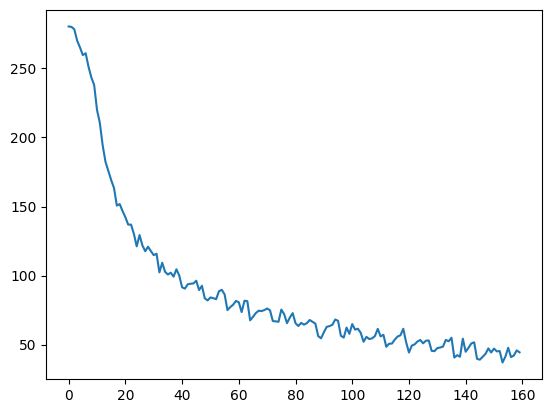

In [48]:
plt.plot(loss_over_time)